In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timeit

%matplotlib inline

In [2]:
import os
from skimage.io import imread
from scipy.io import loadmat

In [3]:
# Data Utils
def load_images(path):
    path += "images/"
    train_path = path + "/train/"
    val_path = path + "/val/"
    test_path = path + "/test/"

    x_train = []
    train_list = sorted(os.listdir(train_path))	
    for img in train_list:
        if img.endswith("jpg"):
            x_train.append(imread(train_path+img))


    x_val = []
    val_list = sorted(os.listdir(val_path))
    for img in val_list:
        if img.endswith("jpg"):
            x_val.append(imread(val_path+img))


    x_test = []
    test_list = sorted(os.listdir(test_path))
    for img in test_list:
        if img.endswith("jpg"):
            x_test.append(imread(test_path+img))

    return x_train, x_val, x_test


def load_ground_truth(path):
    path += "groundTruth/"
    train_path = path + "/train/"
    val_path = path + "/val/"
    test_path = path + "/test/"

    y_train = []
    train_list = sorted(os.listdir(train_path))
    for img in train_list:
        if img.endswith("mat"):
            y_train.append(loadmat(train_path+img))


    y_val = []
    val_list = sorted(os.listdir(val_path))
    for img in val_list:
        if img.endswith("mat"):
            y_val.append(loadmat(val_path+img))


    y_test = []
    test_list = sorted(os.listdir(test_path))
    for img in test_list:
        if img.endswith("mat"):
            y_test.append(loadmat(test_path+img))

    return y_train, y_val, y_test

def load_segmentations(path, IDs):
    files_list = sorted(os.listdir(path))
    images = []
    for ID in IDs:
        segs = []
        prefix = str(ID)+"-"
        for fn in files_list:
          if prefix == fn[0:len(prefix)]:
            segs.append(imread(path+fn))
        images.append(segs)

    return images
  

get_truthes = lambda grnd : [grnd['groundTruth'][:,i][0][0][0][0] for i in range(grnd['groundTruth'].shape[1])]

In [4]:
# Visual
def plot_img_with_gnd(image, img, grnd_truth, size=(30,20)):
    fig = plt.figure(figsize=size)
    ground_truthes = get_truthes(grnd_truth)
    num_columns = len(ground_truthes) + 2
    fig.add_subplot(1, num_columns, 1)
    plt.imshow(image, cmap = 'gray')
    plt.axis('off')
    fig.add_subplot(1, num_columns, 2)
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')
    for i in range(len(ground_truthes)):
        ax = fig.add_subplot(1, num_columns, i+3)
        ax.set_title("Ground truth_{}".format(i+1))
        # plt.imshow(ground_truthes[i], cmap='Greys_r')
        plt.imshow(ground_truthes[i], cmap = 'gray')
        plt.axis('off')


def plot_images_truths(images, img, ground_truth, size=(30,20)):
    for i in range(len(images)):
        plot_img_with_gnd(images[i], img[i], ground_truth[i], size)


def plot_k_performance(k_means, f_average, c_average, normalized=False, title=""):
    # data to plot
    n_groups = len(k_means)
    f_measures = f_average
    cond_entropies = c_average
    
    if normalized:
        f_measures = (np.array(f_measures) - np.min(f_measures))/(np.max(f_measures) - np.min(f_measures))
        cond_entropies = (np.array(cond_entropies) - np.min(cond_entropies))/(np.max(cond_entropies) - np.min(cond_entropies))
        title += " (Normalized)"
    else:
        title += " (Not Normalized)"
    # create plot
    fig, ax = plt.subplots(figsize=(12,8))
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8
     
    rects1 = plt.bar(index, f_measures, bar_width,
                     alpha=opacity,
                     color='b',
                     label='f_measure')
     
    rects2 = plt.bar(index + bar_width, cond_entropies, bar_width,
                     alpha=opacity,
                     color='g',
                     label='cond. entropy')
     
    plt.xlabel('K')
    plt.ylabel('Scores')
    plt.title(title)
    plt.xticks(index + bar_width, tuple(k_means) )
    plt.legend()
     
    plt.tight_layout()
    plt.show()


In [5]:
def f_measure(seg, grnd):
    clusters = np.unique(seg).tolist()
    F = 0
    for c in clusters:
        indeces = np.where(seg==c)
        # precision
        (values, counts) = np.unique(grnd[indeces], return_counts=True)
        ind = np.argmax(counts)
        max_val = values[ind]
        occurances = counts[ind]
        prec = occurances/ len(indeces[0])
        # recall
        rec = occurances / len(grnd[grnd==max_val])
        f = 2*prec*rec / (prec+rec)
        F += f
    F /= len(clusters)
    return F

In [6]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import v_measure_score

In [7]:
class ClusterAlgorithm(object):
    """docstring for ClusterAlgorithm"""
    def __init__(self):
        pass

    def train(self, x_train, y_train, save_path=None, verbose=False):
        """save_path: if not None, segmentation results will be saved under specified folder
            verbose: set to true if you want to print details of the calculated performance
        """
        if (len(x_train) != len(y_train)):
            raise Exception("Unmatched data sizes: X={} vs y={}".format(len(x_train), len(y_train)))

        f_per_k = []
        c_per_k = []
        for i in range(len(x_train)):
            print("Image#{}".format(i+1))
            k_segmentations = self.get_segmentations(x_train[i])
            if save_path != None:
                self.save_to_path(k_segmentations, save_path)
            ground_truths = get_truthes(y_train[i])
            f_measures, cond_entropies = self.calc_performance(k_segmentations, ground_truths, verbose=verbose)
            f_per_k.append(f_measures)
            c_per_k.append(cond_entropies)

        f_average = np.array(f_per_k).mean(axis=0)
        c_average = np.array(c_per_k).mean(axis=0)
        for i in range(len(f_average)):
            k = self.k_means[i]
            f = f_average[i]
            c = c_average[i]
            print("K={}: Total average f-measure={:.4f}, Total average cond_entropies={:.4f}".format(k, f, c))

        return f_average, c_average 

    
    def get_segmentations(self, image, k_means):
        pass


    def calc_performance(self, segmentations, ground_truths, verbose=False):
        num_truthes = len(ground_truths)
        f_per_seg = []
        c_per_seg = []
        for i, seg in enumerate(segmentations):
            k = self.k_means[i]
            f = 0
            c=0
            for j in range(num_truthes):
                fm = f_measure(seg, ground_truths[j])
                cond_entropy = v_measure_score(seg.flat, ground_truths[j].flat)
                f += fm
                c += cond_entropy
                if verbose:
                    print("k:{} VS gorund-truth:{} => f={:.4f}, c={:.4f}".format(k,j+1, fm, cond_entropy))
            f /= num_truthes
            c /= num_truthes
            f_per_seg.append(f)
            c_per_seg.append(c)
            print("k={}: Avg. f-measue={:.4f} , Avg. conditional entropy={:.4f}\n".format(k, f, c))
        return f_per_seg, c_per_seg


    def save_to_path(self, path):
        pass


Plot image vs ground truth

In [8]:
PATH = 'BSR/BSDS500/data/'

x_train, x_val, x_test = load_images(PATH)
y_train, y_val, y_test = load_ground_truth(PATH)

In [9]:
font = {'size'   : 23}
plt.rc('font', **font)

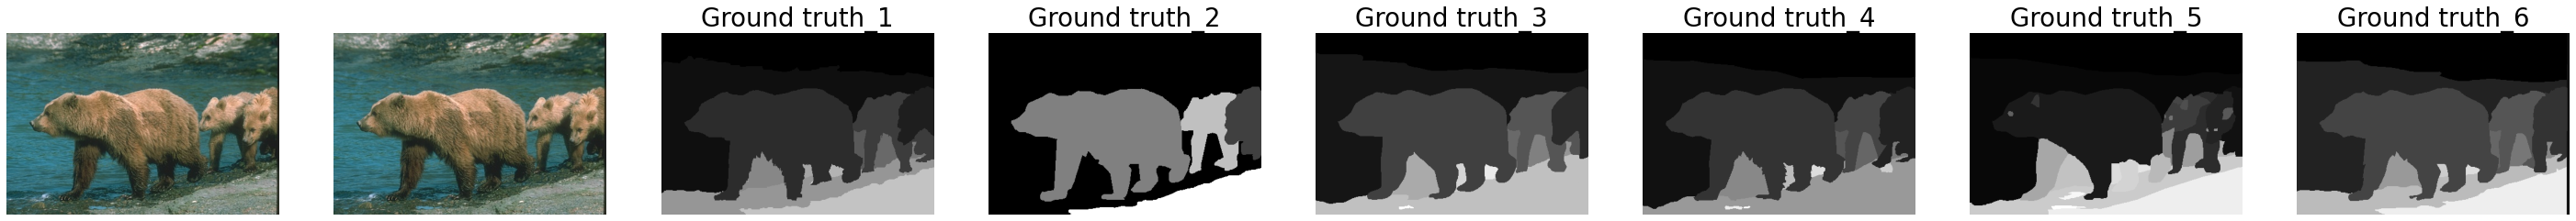

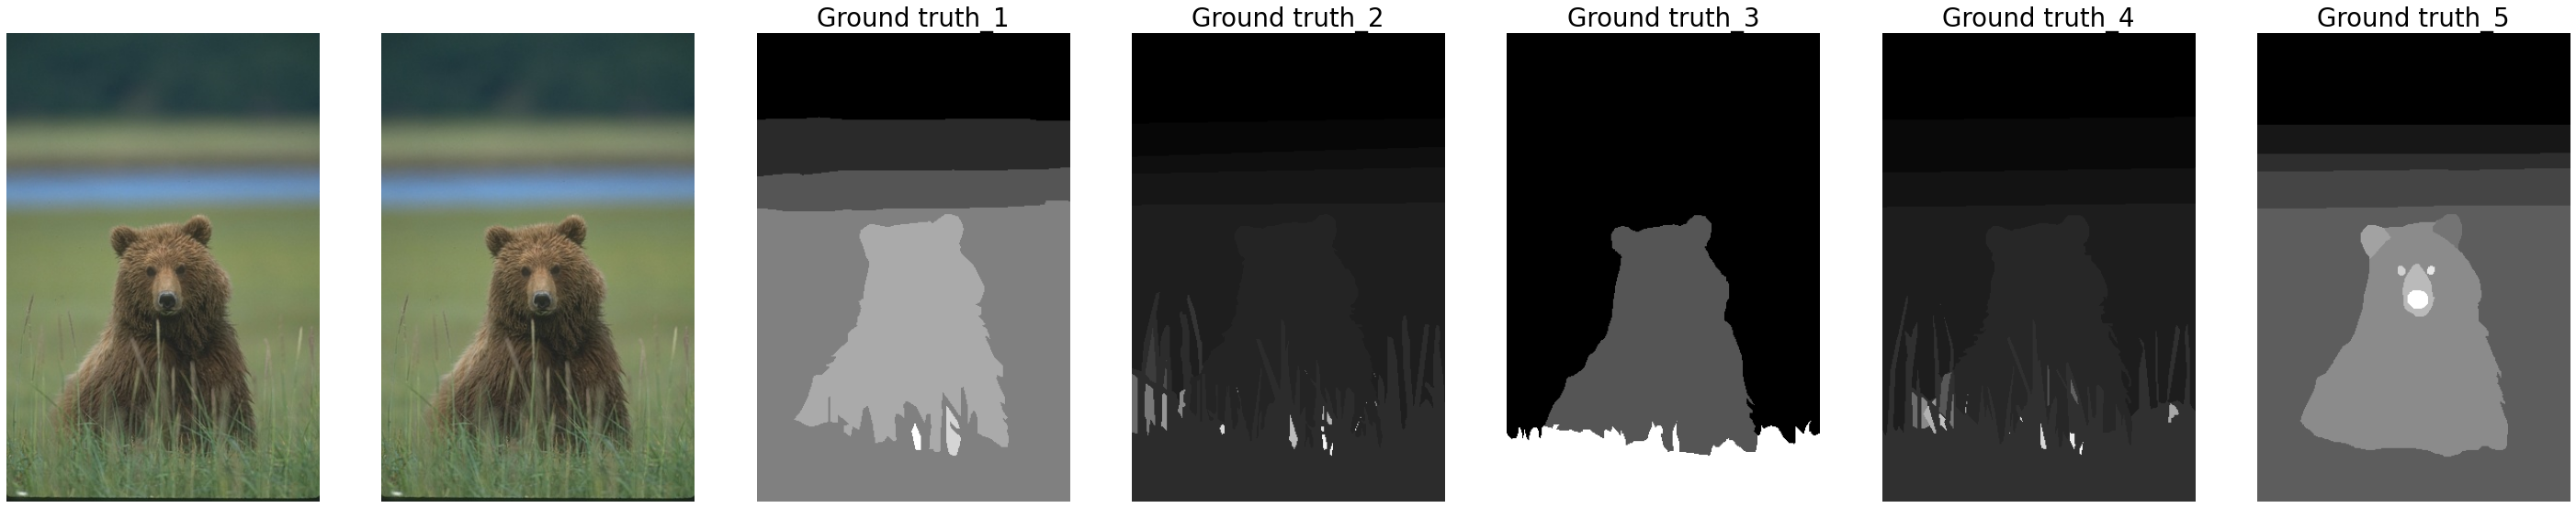

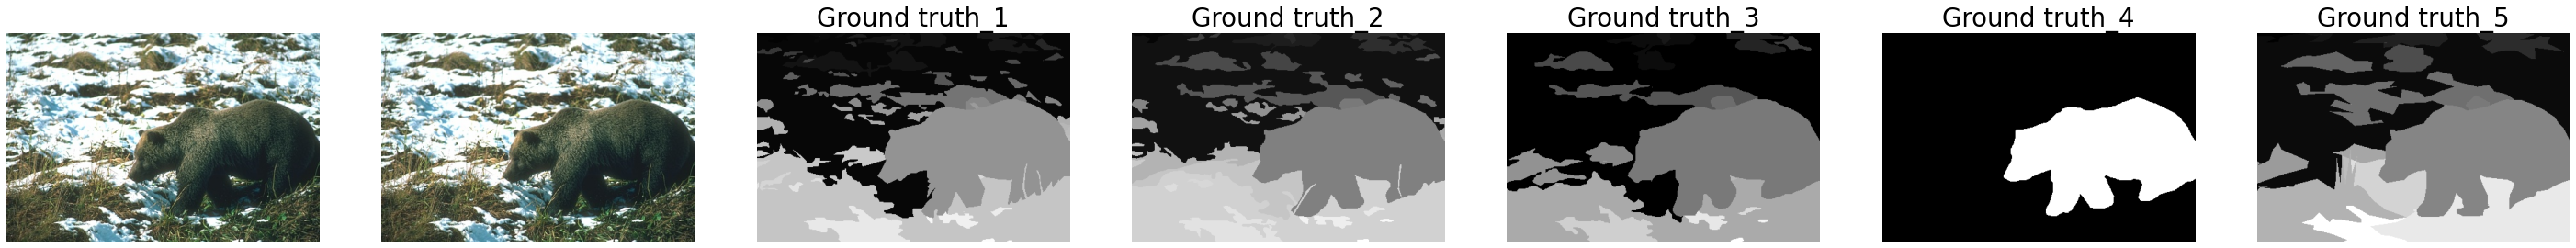

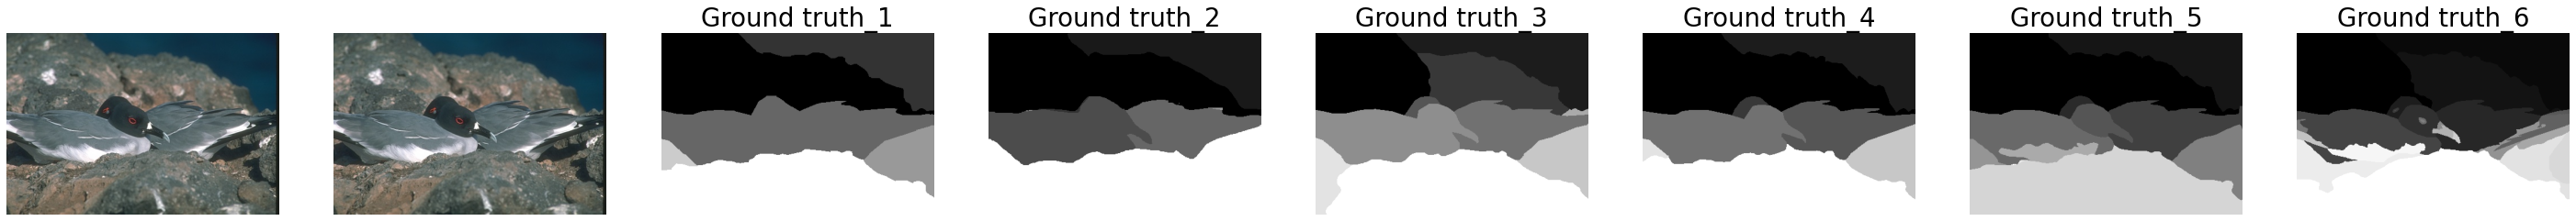

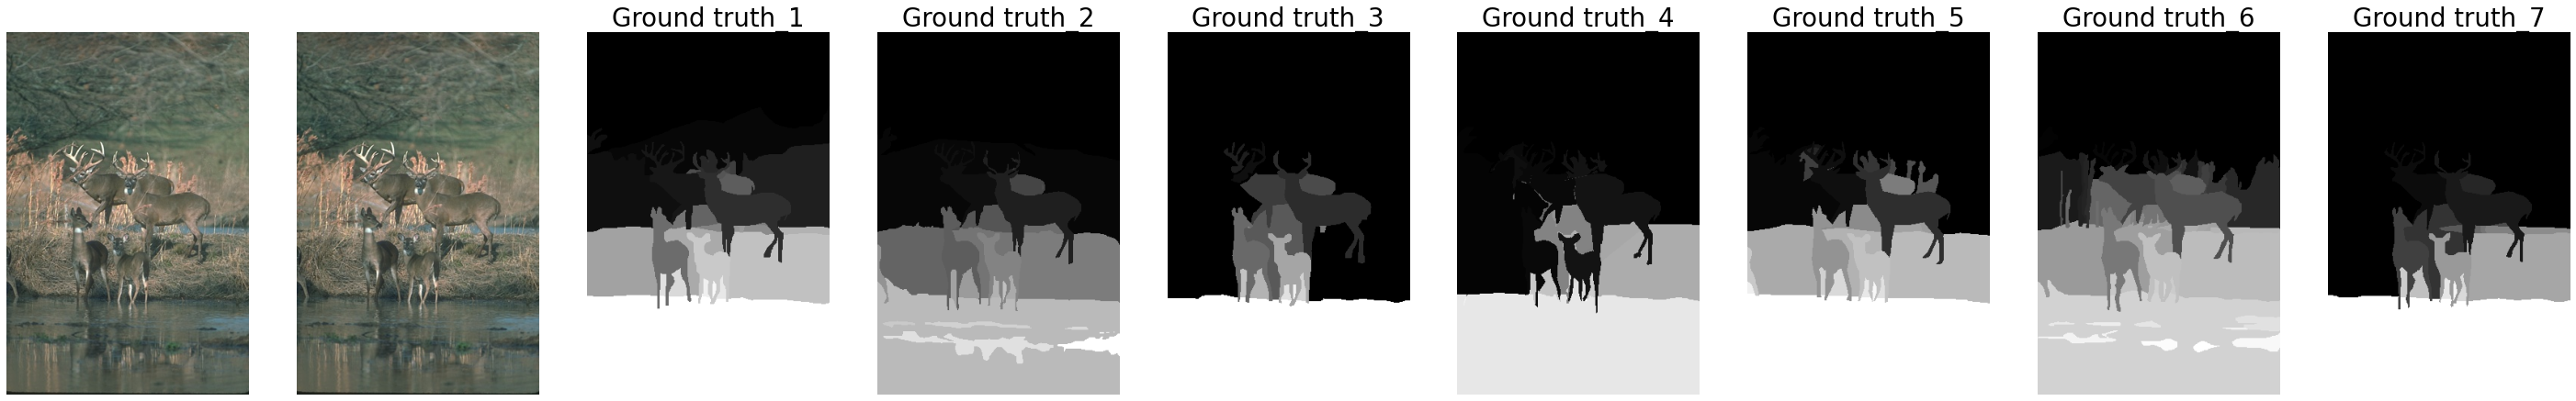

In [10]:
plot_images_truths(x_train[0:5], x_train[0:5], y_train[0:5], size=(50,50))

Normalized Cut

In [11]:
from sklearn.cluster import SpectralClustering
import numpy as np
from sklearn.metrics.cluster import v_measure_score
import cv2


class NormalizedCut(object):
    """docstring for ClusterAlgorithm"""
    def __init__(self, gamma=1, k_means=5, affinity='rbf'):
        self.gamma = gamma
        self.k_means = k_means
        self.affinity = affinity

    def train(self, x_train, y_train, save_path=None, verbose=False):
        """save_path: if not None, segmentation results will be saved under specified folder
            verbose: set to true if you want to print details of the calculated performance
        """
        if (len(x_train) != len(y_train)):
            raise Exception("Unmatched data sizes: X={} vs y={}".format(len(x_train), len(y_train)))

        f_per_k = []
        c_per_k = []
        for i in range(len(x_train)):
            print("Image#{}".format(i+1))
            k_segmentations = self.get_segmentations(x_train[i])
            if save_path != None:
                self.save_to_path(k_segmentations, save_path)
            ground_truths = get_truthes(y_train[i])
            f_measures, cond_entropies = self.calc_performance(k_segmentations, ground_truths, verbose=verbose)
            f_per_k.append(f_measures)
            c_per_k.append(cond_entropies)

        f_average = np.array(f_per_k).mean(axis=0)
        c_average = np.array(c_per_k).mean(axis=0)
        for i in range(len(f_average)):
            k = self.k_means[i]
            f = f_average[i]
            c = c_average[i]
            print("K={}: Total average f-measure={:.4f}, Total average cond_entropies={:.4f}".format(k, f, c))

        return f_average, c_average

    def get_segmentations(self, image):
        if self.affinity not in ['rbf','nearest_neighbors']:
            raise Exception("affinity must be rbf or nearest_neighbors only")
        image = cv2.resize(image, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
        x, y, z = image.shape[0], image.shape[1], image.shape[2]
        image = np.reshape(image, (x*y, z))
        k_segmentations = []
        for n in self.k_means:
            clustering = SpectralClustering(n_clusters=n, affinity=self.affinity, eigen_tol=0.001, gamma=self.gamma, n_neighbors=20 , n_jobs=-1, eigen_solver='arpack', random_state=0)
            clustering.fit(image)
            segmentation = clustering.labels_.reshape(x, y)
            k_segmentations.append(segmentation)

        return k_segmentations
    
    def calc_performance(self, segmentations, ground_truths, verbose=False):
        num_truthes = len(ground_truths)
        f_per_seg = []
        c_per_seg = []
        for i, seg in enumerate(segmentations):
            k = self.k_means[i]
            f = 0
            c=0
            for j in range(num_truthes):
                gt = cv2.resize(ground_truths[j], dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
                fm = f_measure(seg, gt)
                cond_entropy = v_measure_score(seg.flat, gt.flat)
                f += fm
                c += cond_entropy
                if verbose:
                    print("k:{} VS gorund-truth:{} => f={:.4f}, c={:.4f}".format(k,j+1, fm, cond_entropy))
            f /= num_truthes
            c /= num_truthes
            f_per_seg.append(f)
            c_per_seg.append(c)
            print("k={}: Avg. f-measure={:.4f} , Avg. conditional entropy={:.4f}\n".format(k, f, c))
        return f_per_seg, c_per_seg


In [12]:
gamma = [1,10, 100]
n_clusters = [3,5,7,9,11]
affinity = ['rbf', 'nearest_neighbors']

In [13]:
nc = NormalizedCut(gamma[0], n_clusters, affinity[0])
start = timeit.default_timer()
f_average_1, c_average_1 = nc.train(x_train, y_train, verbose=False)
stop = timeit.default_timer()
print("Time elapsed:{:0.2f} seconds".format(stop-start))

Image#1
k=3: Avg. f-measure=0.2353 , Avg. conditional entropy=0.0020

k=5: Avg. f-measure=0.2353 , Avg. conditional entropy=0.0020

k=7: Avg. f-measure=0.2353 , Avg. conditional entropy=0.0020

k=9: Avg. f-measure=0.2353 , Avg. conditional entropy=0.0020

k=11: Avg. f-measure=0.2353 , Avg. conditional entropy=0.0020

Image#2
k=3: Avg. f-measure=0.3857 , Avg. conditional entropy=0.0050

k=5: Avg. f-measure=0.3857 , Avg. conditional entropy=0.0050

k=7: Avg. f-measure=0.3857 , Avg. conditional entropy=0.0050

k=9: Avg. f-measure=0.3857 , Avg. conditional entropy=0.0050

k=11: Avg. f-measure=0.3857 , Avg. conditional entropy=0.0050

Image#3
k=3: Avg. f-measure=0.2978 , Avg. conditional entropy=0.0013

k=5: Avg. f-measure=0.2978 , Avg. conditional entropy=0.0013

k=7: Avg. f-measure=0.2978 , Avg. conditional entropy=0.0013

k=9: Avg. f-measure=0.2978 , Avg. conditional entropy=0.0013

k=11: Avg. f-measure=0.2978 , Avg. conditional entropy=0.0013

Image#4
k=3: Avg. f-measure=0.1943 , Avg. c

In [14]:
nc = NormalizedCut(10, n_clusters, affinity[0])
start = timeit.default_timer()
f_average_10, c_average_10 = nc.train(x_train, y_train, verbose=False)
stop = timeit.default_timer()
print("Time elapsed:{:0.2f} seconds".format(stop-start))

Image#1
k=3: Avg. f-measure=0.1783 , Avg. conditional entropy=0.0080

k=5: Avg. f-measure=0.1148 , Avg. conditional entropy=0.0120

k=7: Avg. f-measure=0.0852 , Avg. conditional entropy=0.0160

k=9: Avg. f-measure=0.0778 , Avg. conditional entropy=0.0191

k=11: Avg. f-measure=0.0695 , Avg. conditional entropy=0.0251

Image#2
k=3: Avg. f-measure=0.5592 , Avg. conditional entropy=0.0000

k=5: Avg. f-measure=0.5592 , Avg. conditional entropy=0.0000

k=7: Avg. f-measure=0.5592 , Avg. conditional entropy=0.0000

k=9: Avg. f-measure=0.5592 , Avg. conditional entropy=0.0000

k=11: Avg. f-measure=0.5592 , Avg. conditional entropy=0.0000

Image#3
k=3: Avg. f-measure=0.5903 , Avg. conditional entropy=0.0000

k=5: Avg. f-measure=0.3209 , Avg. conditional entropy=0.0050

k=7: Avg. f-measure=0.3222 , Avg. conditional entropy=0.0022

k=9: Avg. f-measure=0.1607 , Avg. conditional entropy=0.0247

k=11: Avg. f-measure=0.1575 , Avg. conditional entropy=0.0287

Image#4
k=3: Avg. f-measure=0.1916 , Avg. c

In [15]:
nc = NormalizedCut(20, n_clusters, affinity[0])
start = timeit.default_timer()
f_average_20, c_average_20 = nc.train(x_train, y_train, verbose=False)
stop = timeit.default_timer()
print("Time elapsed:{:0.2f} seconds".format(stop-start))

Image#1
k=3: Avg. f-measure=0.2353 , Avg. conditional entropy=0.0020

k=5: Avg. f-measure=0.1035 , Avg. conditional entropy=0.0111

k=7: Avg. f-measure=0.2353 , Avg. conditional entropy=0.0020

k=9: Avg. f-measure=0.2353 , Avg. conditional entropy=0.0020

k=11: Avg. f-measure=0.0667 , Avg. conditional entropy=0.0221

Image#2
k=3: Avg. f-measure=0.5592 , Avg. conditional entropy=0.0000

k=5: Avg. f-measure=0.5592 , Avg. conditional entropy=0.0000

k=7: Avg. f-measure=0.5592 , Avg. conditional entropy=0.0000

k=9: Avg. f-measure=0.5592 , Avg. conditional entropy=0.0000

k=11: Avg. f-measure=0.5592 , Avg. conditional entropy=0.0000

Image#3
k=3: Avg. f-measure=0.2061 , Avg. conditional entropy=0.0098

k=5: Avg. f-measure=0.1278 , Avg. conditional entropy=0.0142

k=7: Avg. f-measure=0.1172 , Avg. conditional entropy=0.0164

k=9: Avg. f-measure=0.0979 , Avg. conditional entropy=0.0204

k=11: Avg. f-measure=0.3011 , Avg. conditional entropy=0.0029

Image#4
k=3: Avg. f-measure=0.4417 , Avg. c

In [16]:
nc = NormalizedCut(30, n_clusters, affinity[0])
start = timeit.default_timer()
f_average_1, c_average_1 = nc.train(x_train, y_train, verbose=False)
stop = timeit.default_timer()
print("Time elapsed:{:0.2f} seconds".format(stop-start))

Image#1
k=3: Avg. f-measure=0.4592 , Avg. conditional entropy=0.0000

k=5: Avg. f-measure=0.4592 , Avg. conditional entropy=0.0000

k=7: Avg. f-measure=0.2519 , Avg. conditional entropy=0.0054

k=9: Avg. f-measure=0.2519 , Avg. conditional entropy=0.0054

k=11: Avg. f-measure=0.2519 , Avg. conditional entropy=0.0054

Image#2
k=3: Avg. f-measure=0.1987 , Avg. conditional entropy=0.0080

k=5: Avg. f-measure=0.1241 , Avg. conditional entropy=0.0125

k=7: Avg. f-measure=0.0918 , Avg. conditional entropy=0.0161

k=9: Avg. f-measure=0.0734 , Avg. conditional entropy=0.0207

k=11: Avg. f-measure=0.0626 , Avg. conditional entropy=0.0274

Image#3
k=3: Avg. f-measure=0.5903 , Avg. conditional entropy=0.0000

k=5: Avg. f-measure=0.2997 , Avg. conditional entropy=0.0027

k=7: Avg. f-measure=0.2997 , Avg. conditional entropy=0.0027

k=9: Avg. f-measure=0.2997 , Avg. conditional entropy=0.0027

k=11: Avg. f-measure=0.2997 , Avg. conditional entropy=0.0027

Image#4
k=3: Avg. f-measure=0.1544 , Avg. c

In [17]:
nc = NormalizedCut(40, n_clusters, affinity[0])
start = timeit.default_timer()
f_average_40, c_average_40 = nc.train(x_train, y_train, verbose=False)
stop = timeit.default_timer()
print("Time elapsed:{:0.2f} seconds".format(stop-start))

Image#1
k=3: Avg. f-measure=0.4592 , Avg. conditional entropy=0.0000

k=5: Avg. f-measure=0.4592 , Avg. conditional entropy=0.0000

k=7: Avg. f-measure=0.4592 , Avg. conditional entropy=0.0000

k=9: Avg. f-measure=0.4592 , Avg. conditional entropy=0.0000

k=11: Avg. f-measure=0.4592 , Avg. conditional entropy=0.0000

Image#2
k=3: Avg. f-measure=0.1992 , Avg. conditional entropy=0.0113

k=5: Avg. f-measure=0.1270 , Avg. conditional entropy=0.0203

k=7: Avg. f-measure=0.0913 , Avg. conditional entropy=0.0194

k=9: Avg. f-measure=0.0719 , Avg. conditional entropy=0.0208

k=11: Avg. f-measure=0.0610 , Avg. conditional entropy=0.0273

Image#3
k=3: Avg. f-measure=0.5903 , Avg. conditional entropy=0.0000

k=5: Avg. f-measure=0.5903 , Avg. conditional entropy=0.0000

k=7: Avg. f-measure=0.5903 , Avg. conditional entropy=0.0000

k=9: Avg. f-measure=0.5903 , Avg. conditional entropy=0.0000

k=11: Avg. f-measure=0.5903 , Avg. conditional entropy=0.0000

Image#4
k=3: Avg. f-measure=0.4417 , Avg. c

Nearest Neighbour

In [18]:
nc = NormalizedCut(k_means=n_clusters, affinity=affinity[1]) #10 neighbours
start = timeit.default_timer()
f_average_10NN, c_average_NN = nc.train(x_train, y_train, verbose=False)
stop = timeit.default_timer()
print("Time elapsed:{:0.2f} seconds".format(stop-start))

Image#1
k=3: Avg. f-measure=0.5173 , Avg. conditional entropy=0.2405

k=5: Avg. f-measure=0.4829 , Avg. conditional entropy=0.3268

k=7: Avg. f-measure=0.4379 , Avg. conditional entropy=0.3466

k=9: Avg. f-measure=0.4020 , Avg. conditional entropy=0.3632

k=11: Avg. f-measure=0.3634 , Avg. conditional entropy=0.3801

Image#2
k=3: Avg. f-measure=0.5829 , Avg. conditional entropy=0.2891

k=5: Avg. f-measure=0.6654 , Avg. conditional entropy=0.5577

k=7: Avg. f-measure=0.5712 , Avg. conditional entropy=0.5105

k=9: Avg. f-measure=0.5080 , Avg. conditional entropy=0.4993

k=11: Avg. f-measure=0.4742 , Avg. conditional entropy=0.5207

Image#3
k=3: Avg. f-measure=0.5524 , Avg. conditional entropy=0.2478

k=5: Avg. f-measure=0.4451 , Avg. conditional entropy=0.2562

k=7: Avg. f-measure=0.3588 , Avg. conditional entropy=0.2540

k=9: Avg. f-measure=0.2929 , Avg. conditional entropy=0.2477

k=11: Avg. f-measure=0.2491 , Avg. conditional entropy=0.2499

Image#4
k=3: Avg. f-measure=0.5992 , Avg. c

In [19]:
nc = NormalizedCut(k_means=n_clusters, affinity=affinity[1])#20 neighbous
start = timeit.default_timer()
f_average_20NN, c_average_20NN = nc.train(x_train, y_train, verbose=False)
stop = timeit.default_timer()
print("Time elapsed:{:0.2f} seconds".format(stop-start))

Image#1
k=3: Avg. f-measure=0.5173 , Avg. conditional entropy=0.2405

k=5: Avg. f-measure=0.4829 , Avg. conditional entropy=0.3268

k=7: Avg. f-measure=0.4379 , Avg. conditional entropy=0.3466

k=9: Avg. f-measure=0.4020 , Avg. conditional entropy=0.3632

k=11: Avg. f-measure=0.3634 , Avg. conditional entropy=0.3801

Image#2
k=3: Avg. f-measure=0.5829 , Avg. conditional entropy=0.2891

k=5: Avg. f-measure=0.6654 , Avg. conditional entropy=0.5577

k=7: Avg. f-measure=0.5712 , Avg. conditional entropy=0.5105

k=9: Avg. f-measure=0.5080 , Avg. conditional entropy=0.4993

k=11: Avg. f-measure=0.4742 , Avg. conditional entropy=0.5207

Image#3
k=3: Avg. f-measure=0.5524 , Avg. conditional entropy=0.2478

k=5: Avg. f-measure=0.4451 , Avg. conditional entropy=0.2562

k=7: Avg. f-measure=0.3588 , Avg. conditional entropy=0.2540

k=9: Avg. f-measure=0.2929 , Avg. conditional entropy=0.2477

k=11: Avg. f-measure=0.2491 , Avg. conditional entropy=0.2499

Image#4
k=3: Avg. f-measure=0.5992 , Avg. c

Display Results

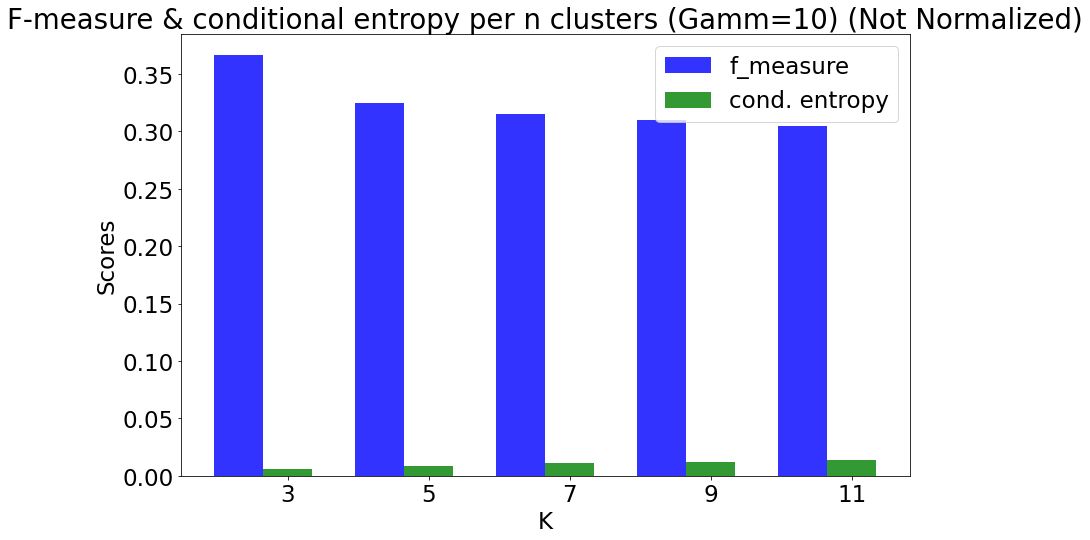

In [20]:
plot_k_performance(n_clusters, f_average_10, c_average_10, normalized=False,
                   title='F-measure & conditional entropy per n clusters (Gamm=10)')

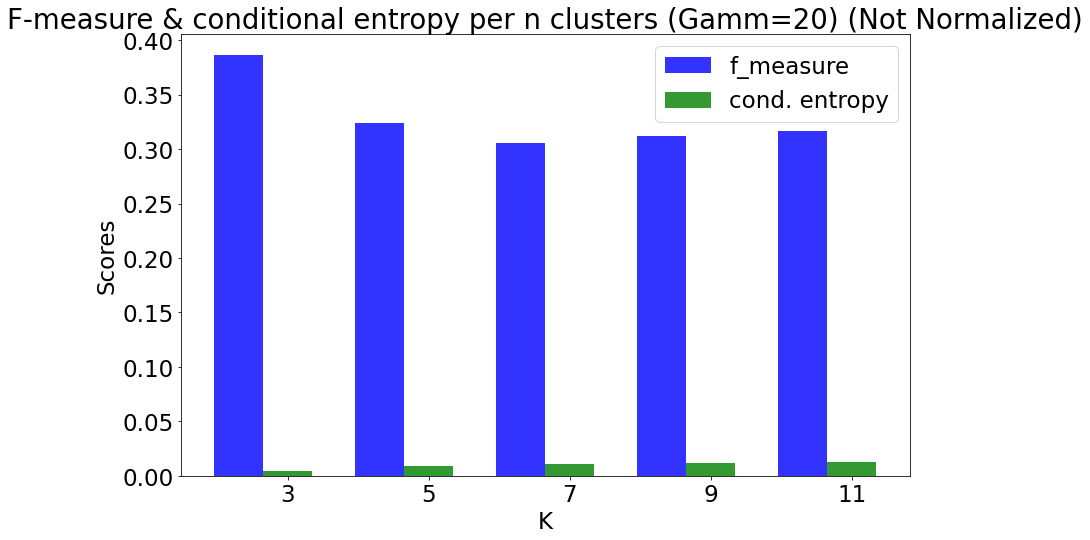

In [21]:
plot_k_performance(n_clusters, f_average_20, c_average_20, normalized=False,
                   title='F-measure & conditional entropy per n clusters (Gamm=20)')

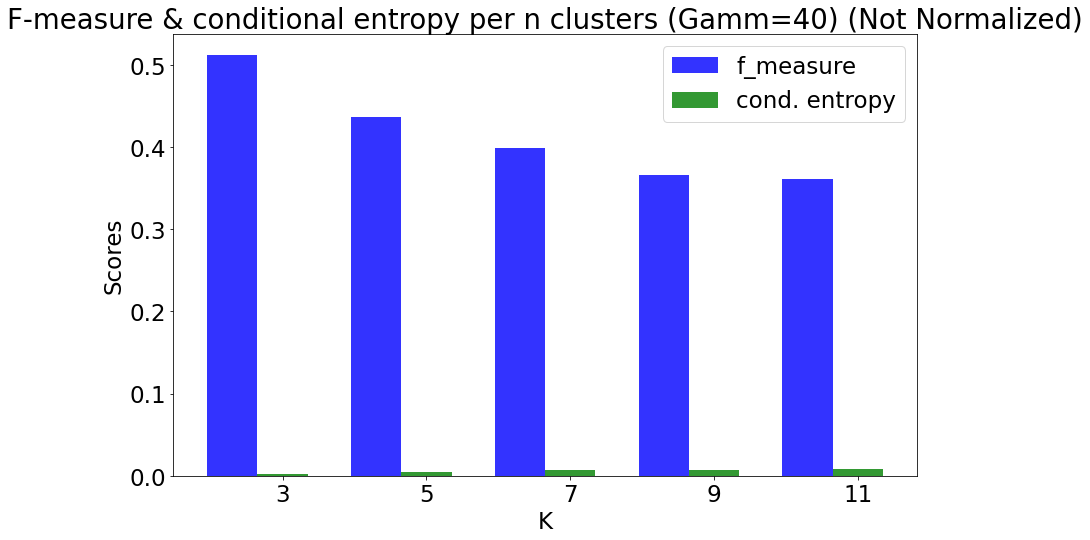

In [22]:
plot_k_performance(n_clusters, f_average_40, c_average_40, normalized=False,
                   title='F-measure & conditional entropy per n clusters (Gamm=40)')

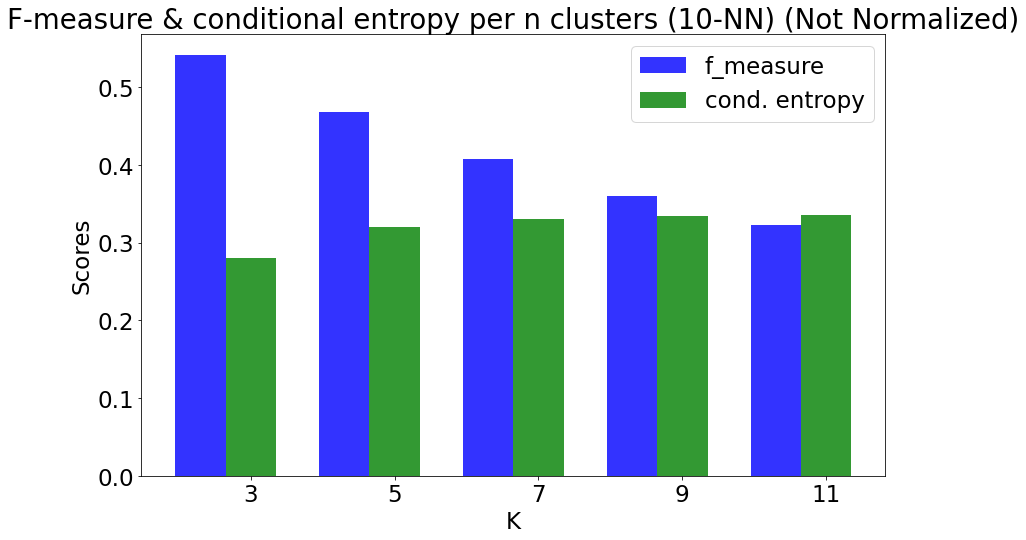

In [23]:
plot_k_performance(n_clusters, f_average_10NN, c_average_NN, normalized=False,
                   title='F-measure & conditional entropy per n clusters (10-NN)')

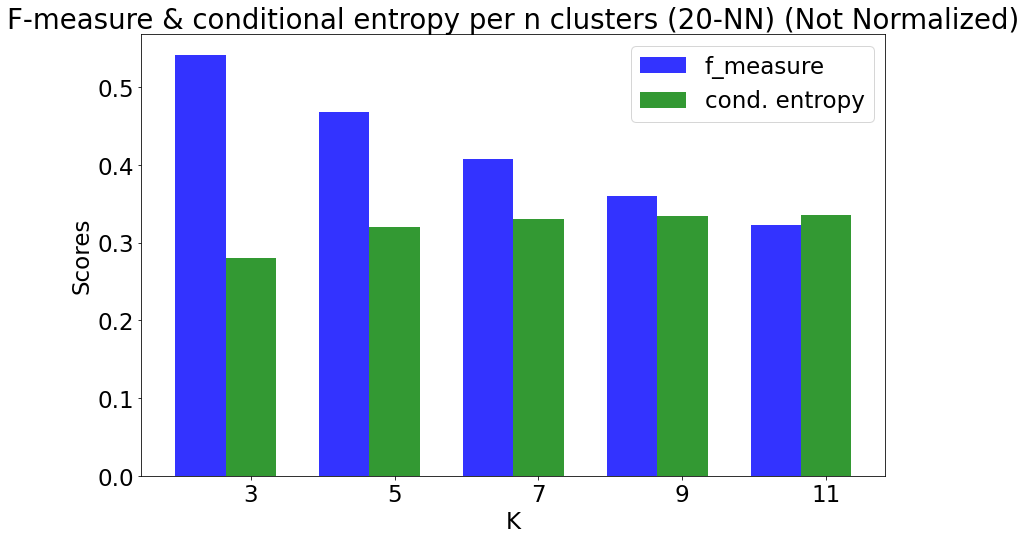

In [24]:
plot_k_performance(n_clusters, f_average_20NN, c_average_20NN, normalized=False,
                   title='F-measure & conditional entropy per n clusters (20-NN)')

In [25]:
random_sample = np.random.randint(0, len(x_train), size=5)
y_five = []
for rs in random_sample:
    y_five.append(y_train[rs])

In [26]:
n_clusters = [3]
nc = NormalizedCut(k_means=n_clusters, affinity=affinity[1])
nc_segs = []
x = []
for i in random_sample:
    s = nc.get_segmentations(x_train[i])
    nc_segs.append(s[0])
    x.append(x_train[i])

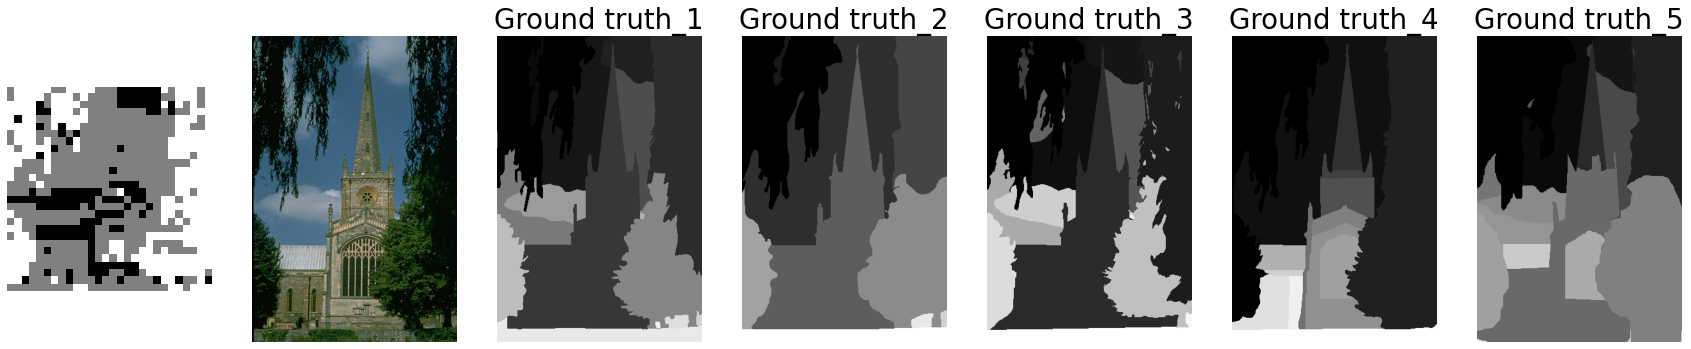

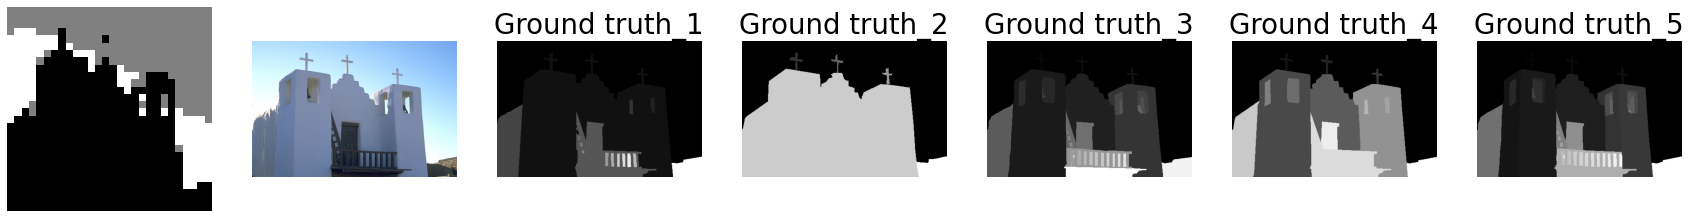

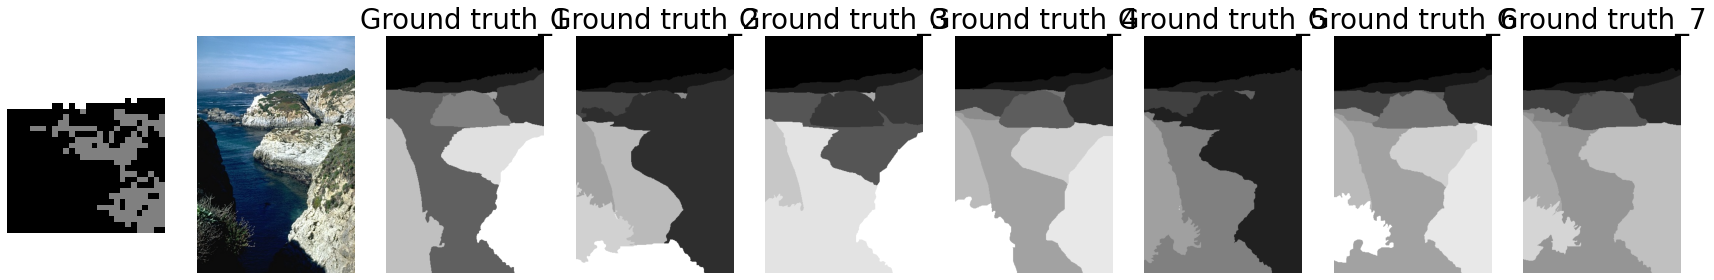

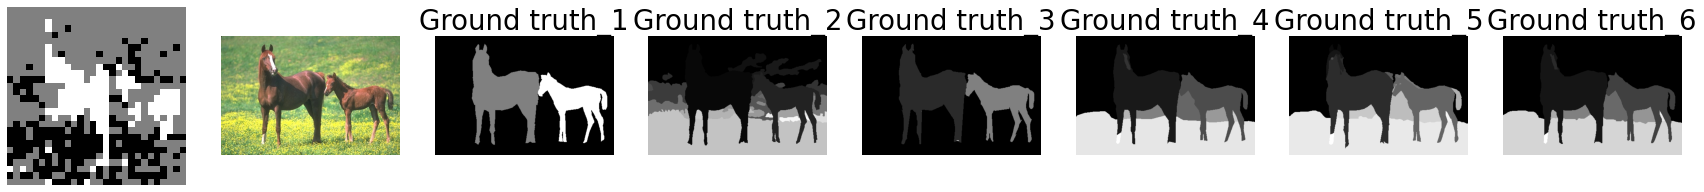

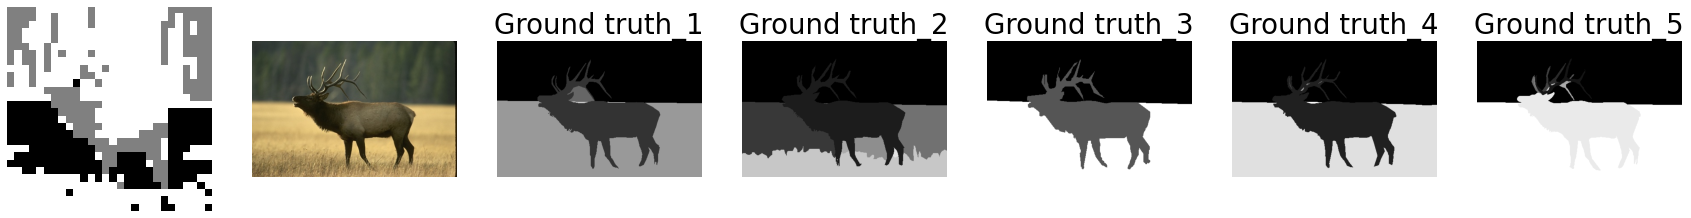

In [27]:
plot_images_truths(nc_segs,x,  y_five, size=(30,20))